<a href="https://colab.research.google.com/github/Rohanmore123/Bigmart_sales/blob/main/sales_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics

In [2]:
#loading a data set from csv file to pandas dataset
bm_data=pd.read_csv('/content/Train.csv')

In [3]:
bm_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
bm_data.shape

(8523, 12)

In [5]:
bm_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


**Catogorical features:**

-item identifier  

-item_fat_content  

-item_types  

-outlet_identifier  

-outlet_size 

-outlet_location_type 

-outlet_type

In [6]:
#checking missimg values in dataset
bm_data.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

we can see that two features have null value ie. Item_Weight and Outlet_Size

In [7]:
bm_data['Item_Weight'].mean()

12.857645184135976

In [8]:
bm_data['Item_Weight'].fillna(bm_data['Item_Weight'].mean(), inplace=True)

In [9]:
# mode of "Outlet_Size" column
bm_data['Outlet_Size'].mode()

0    Medium
dtype: object

In [10]:
mode_outlet_size=bm_data.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x:x.mode()[0]))

In [11]:
print(mode_outlet_size)


Outlet_Type Grocery Store Supermarket Type1 Supermarket Type2  \
Outlet_Size         Small             Small            Medium   

Outlet_Type Supermarket Type3  
Outlet_Size            Medium  


In [12]:
missing_values=bm_data['Outlet_Size'].isnull()

In [13]:
missing_values


0       False
1       False
2       False
3        True
4       False
        ...  
8518    False
8519     True
8520    False
8521    False
8522    False
Name: Outlet_Size, Length: 8523, dtype: bool

In [14]:
bm_data.loc[missing_values,'Outlet_Size']=bm_data.loc[missing_values,'Outlet_Type'].apply(lambda x: mode_outlet_size[x])

In [15]:
bm_data.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

Here we are taking missing values for particular column and again locating the values for outlet size and outlettype 

missing values will be filled based on lambda function

In [16]:
bm_data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.226124,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,12.857645,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [17]:
sns.set

<function seaborn.rcmod.set>

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


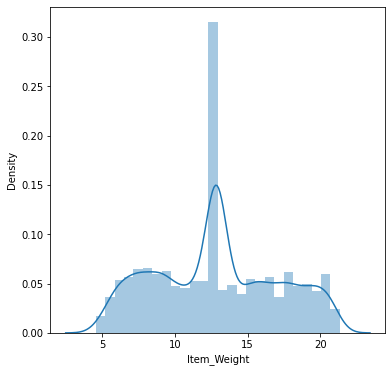

In [18]:
plt.figure(figsize=(6,6))
sns.distplot(bm_data['Item_Weight'])

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


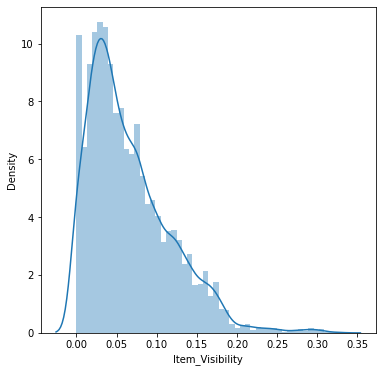

In [19]:
plt.figure(figsize=(6,6))
sns.distplot(bm_data['Item_Visibility'])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


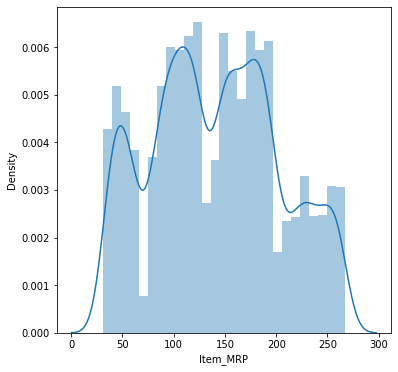

In [20]:
plt.figure(figsize=(6,6))
sns.distplot(bm_data['Item_MRP'])

plt.show()

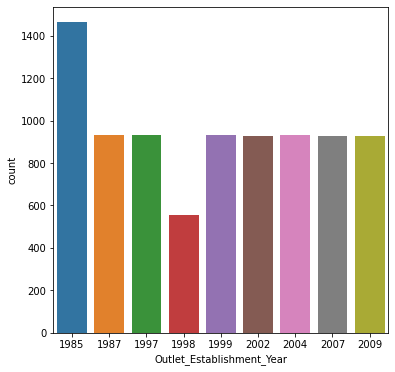

In [21]:
plt.figure(figsize=(6,6))
sns.countplot(x='Outlet_Establishment_Year',data=bm_data)
plt.show()

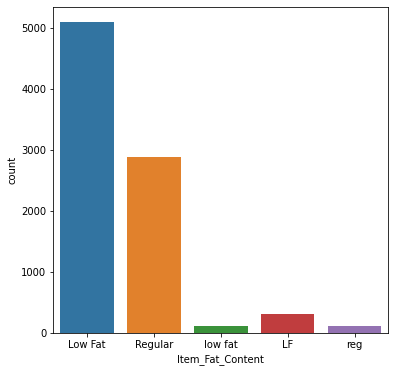

In [22]:
plt.figure(figsize=(6,6))
sns.countplot(x='Item_Fat_Content',data=bm_data)
plt.show()

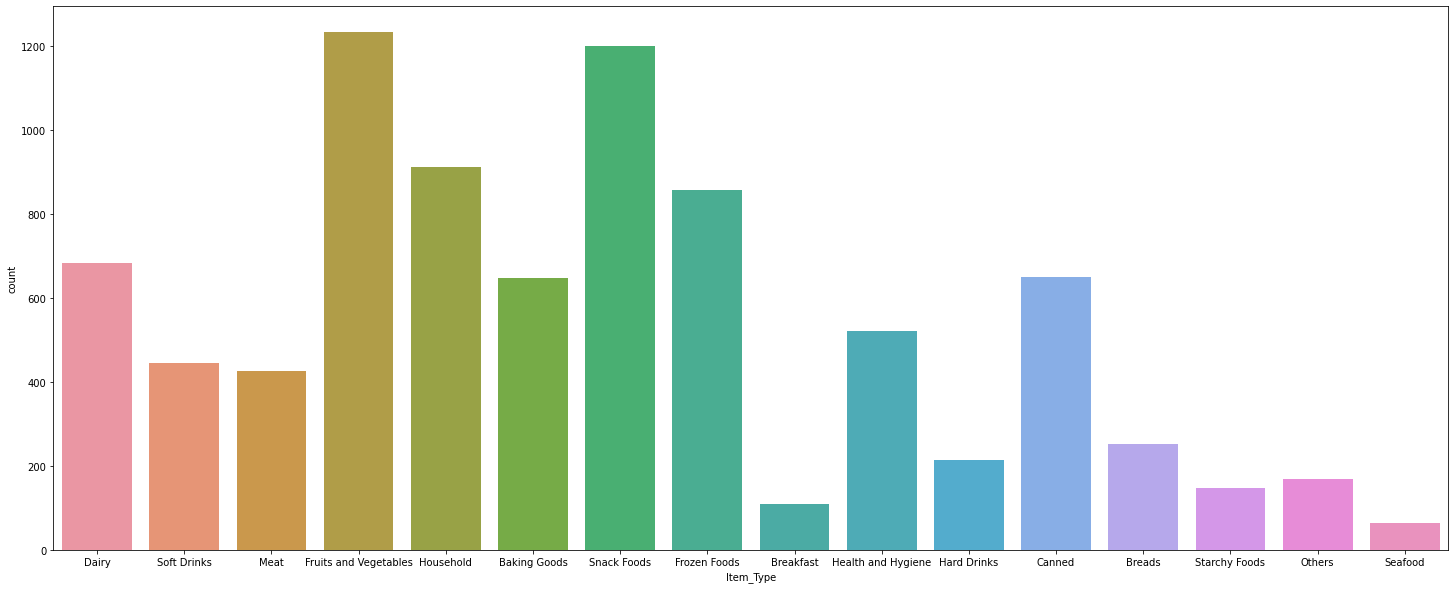

In [23]:
plt.figure(figsize=(25,10))
sns.countplot(x='Item_Type',data=bm_data)
plt.show()

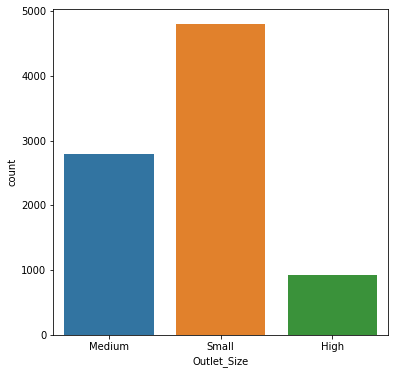

In [24]:
# Outlet_Size column
plt.figure(figsize=(6,6))
sns.countplot(x='Outlet_Size', data=bm_data)
plt.show()

**Data Pre-Processing**

In [25]:
bm_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [26]:
bm_data['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [27]:
bm_data.replace({'Item_Fat_Content':{'Low fat':'Low Fat','LF':'Low Fat','low fat':'Low Fat','reg':'Regular'}}, inplace=True)

In [28]:
bm_data['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [29]:
encoder=LabelEncoder()

In [30]:
bm_data['Item_Identifier']=encoder.fit_transform(bm_data['Item_Identifier'])

In [31]:
bm_data['Item_Fat_Content']=encoder.fit_transform(bm_data['Item_Fat_Content'])
bm_data['Item_Type']=encoder.fit_transform(bm_data['Item_Type'])
bm_data['Outlet_Identifier']=encoder.fit_transform(bm_data['Outlet_Identifier'])
bm_data['Outlet_Size']=encoder.fit_transform(bm_data['Outlet_Size'])
bm_data['Outlet_Location_Type']=encoder.fit_transform(bm_data['Outlet_Location_Type'])
bm_data['Outlet_Type']=encoder.fit_transform(bm_data['Outlet_Type'])

In [32]:
bm_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,156,9.30,0,0.016047,4,249.8092,9,1999,1,0,1,3735.1380
1,8,5.92,1,0.019278,14,48.2692,3,2009,1,2,2,443.4228
2,662,17.50,0,0.016760,10,141.6180,9,1999,1,0,1,2097.2700
3,1121,19.20,1,0.000000,6,182.0950,0,1998,2,2,0,732.3800
4,1297,8.93,0,0.000000,9,53.8614,1,1987,0,2,1,994.7052


In [33]:
X=bm_data.drop(columns='Item_Outlet_Sales',axis=1)
Y=bm_data['Item_Outlet_Sales']

In [34]:
X

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,156,9.300,0,0.016047,4,249.8092,9,1999,1,0,1
1,8,5.920,1,0.019278,14,48.2692,3,2009,1,2,2
2,662,17.500,0,0.016760,10,141.6180,9,1999,1,0,1
3,1121,19.200,1,0.000000,6,182.0950,0,1998,2,2,0
4,1297,8.930,0,0.000000,9,53.8614,1,1987,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...
8518,370,6.865,0,0.056783,13,214.5218,1,1987,0,2,1
8519,897,8.380,1,0.046982,0,108.1570,7,2002,2,1,1
8520,1357,10.600,0,0.035186,8,85.1224,6,2004,2,1,1
8521,681,7.210,1,0.145221,13,103.1332,3,2009,1,2,2


In [35]:
Y

0       3735.1380
1        443.4228
2       2097.2700
3        732.3800
4        994.7052
          ...    
8518    2778.3834
8519     549.2850
8520    1193.1136
8521    1845.5976
8522     765.6700
Name: Item_Outlet_Sales, Length: 8523, dtype: float64

In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

In [37]:
print(X.shape, X_train.shape, X_test.shape)

(8523, 11) (6818, 11) (1705, 11)


#Machine learning Model Training  
**XGBoost Regressor**

In [38]:
regressor = XGBRegressor()

In [39]:
regressor.fit(X_train, Y_train)

[18:47:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [40]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6818 entries, 7173 to 7336
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            6818 non-null   int64  
 1   Item_Weight                6818 non-null   float64
 2   Item_Fat_Content           6818 non-null   int64  
 3   Item_Visibility            6818 non-null   float64
 4   Item_Type                  6818 non-null   int64  
 5   Item_MRP                   6818 non-null   float64
 6   Outlet_Identifier          6818 non-null   int64  
 7   Outlet_Establishment_Year  6818 non-null   int64  
 8   Outlet_Size                6818 non-null   int64  
 9   Outlet_Location_Type       6818 non-null   int64  
 10  Outlet_Type                6818 non-null   int64  
dtypes: float64(3), int64(8)
memory usage: 639.2 KB


#Evaluation

In [41]:
training_data_prediction=regressor.predict(X_train)

In [42]:
r2_train=metrics.r2_score(Y_train,training_data_prediction )

In [43]:
print('R-squared Value:', r2_train)

R-squared Value: 0.6364457030941357


In [44]:
testing_data_prediction=regressor.predict(X_test)

In [45]:
r2_test=metrics.r2_score(Y_test,testing_data_prediction )

In [46]:
print('R-squared Value:', r2_test)


R-squared Value: 0.5867640914432671
